In [1]:
from src.OPFInterface import OPFClassifier # c++
from src.py_opf import OptimumPathForestClassifier # py
from functools import cmp_to_key
import pandas as pd
import numpy as np
from os import listdir
import seaborn as sns
from src.utils import error, read_df, euclidean_distance_classify, dtw_distance_classify
from tqdm import tqdm
from time import time
# plot
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

In [2]:
datasets_df = pd.read_csv('data/DataSummary.csv')

df_names = ["WordSynonyms", "SemgHandSubjectCh2", "PLAID", "MelbournePedestrian", "ChlorineConcentration", "ShapesAll"]
new_df = datasets_df.loc[datasets_df['Name'].isin(df_names)].set_index('Name')
new_df.loc[df_names].reset_index().drop(columns=['ID', 'DTW (learned_w) ', 'Data donor/editor', 'Default rate'])

,Name,Type,Train,Test,Class,Length,ED (w=0),DTW (w=100)
0,WordSynonyms,Image,267,638,25,270,0.3824,0.3511
1,SemgHandSubjectCh2,Spectrum,450,450,5,1500,0.5956,0.2733
2,PLAID,Device,537,537,11,1344,0.4767,0.1639
3,MelbournePedestrian,Traffic,1194,2439,10,24,0.1525,0.2091
4,ChlorineConcentration,Sensor,467,3840,3,166,0.3500,0.3516
5,ShapesAll,Image,600,600,60,512,0.2483,0.2317


In [3]:
df = pd.read_csv('all_errors_2.csv')
df = df[['1NN-ED', 'OPF-ED', '1NN-DTW', 'OPF-DTW']]

# Info

In [4]:
df_names = ["WordSynonyms", "SemgHandSubjectCh2", "PLAID", "MelbournePedestrian", "ChlorineConcentration", "ShapesAll"]

In [5]:
new_df = pd.read_csv('all_errors_3.csv')
new_df = new_df[['name', '1NN-ED', 'OPF-ED', '1NN-DTW', 'OPF-DTW']]
new_df = new_df.loc[new_df['name'].isin(df_names)].set_index('name')
new_df.loc[df_names].round(4)

,1NN-ED,OPF-ED,1NN-DTW,OPF-DTW
name,,,,
WordSynonyms,0.3824,0.3871,0.2649,0.2680
SemgHandSubjectCh2,0.5956,0.2111,0.1200,0.1244
PLAID,0.4767,0.3277,0.0931,0.0987
MelbournePedestrian,0.1525,0.0558,0.0791,0.0836
ChlorineConcentration,0.3500,0.3555,0.3518,0.3607
ShapesAll,0.2483,0.2517,0.2117,0.2217


# MDS

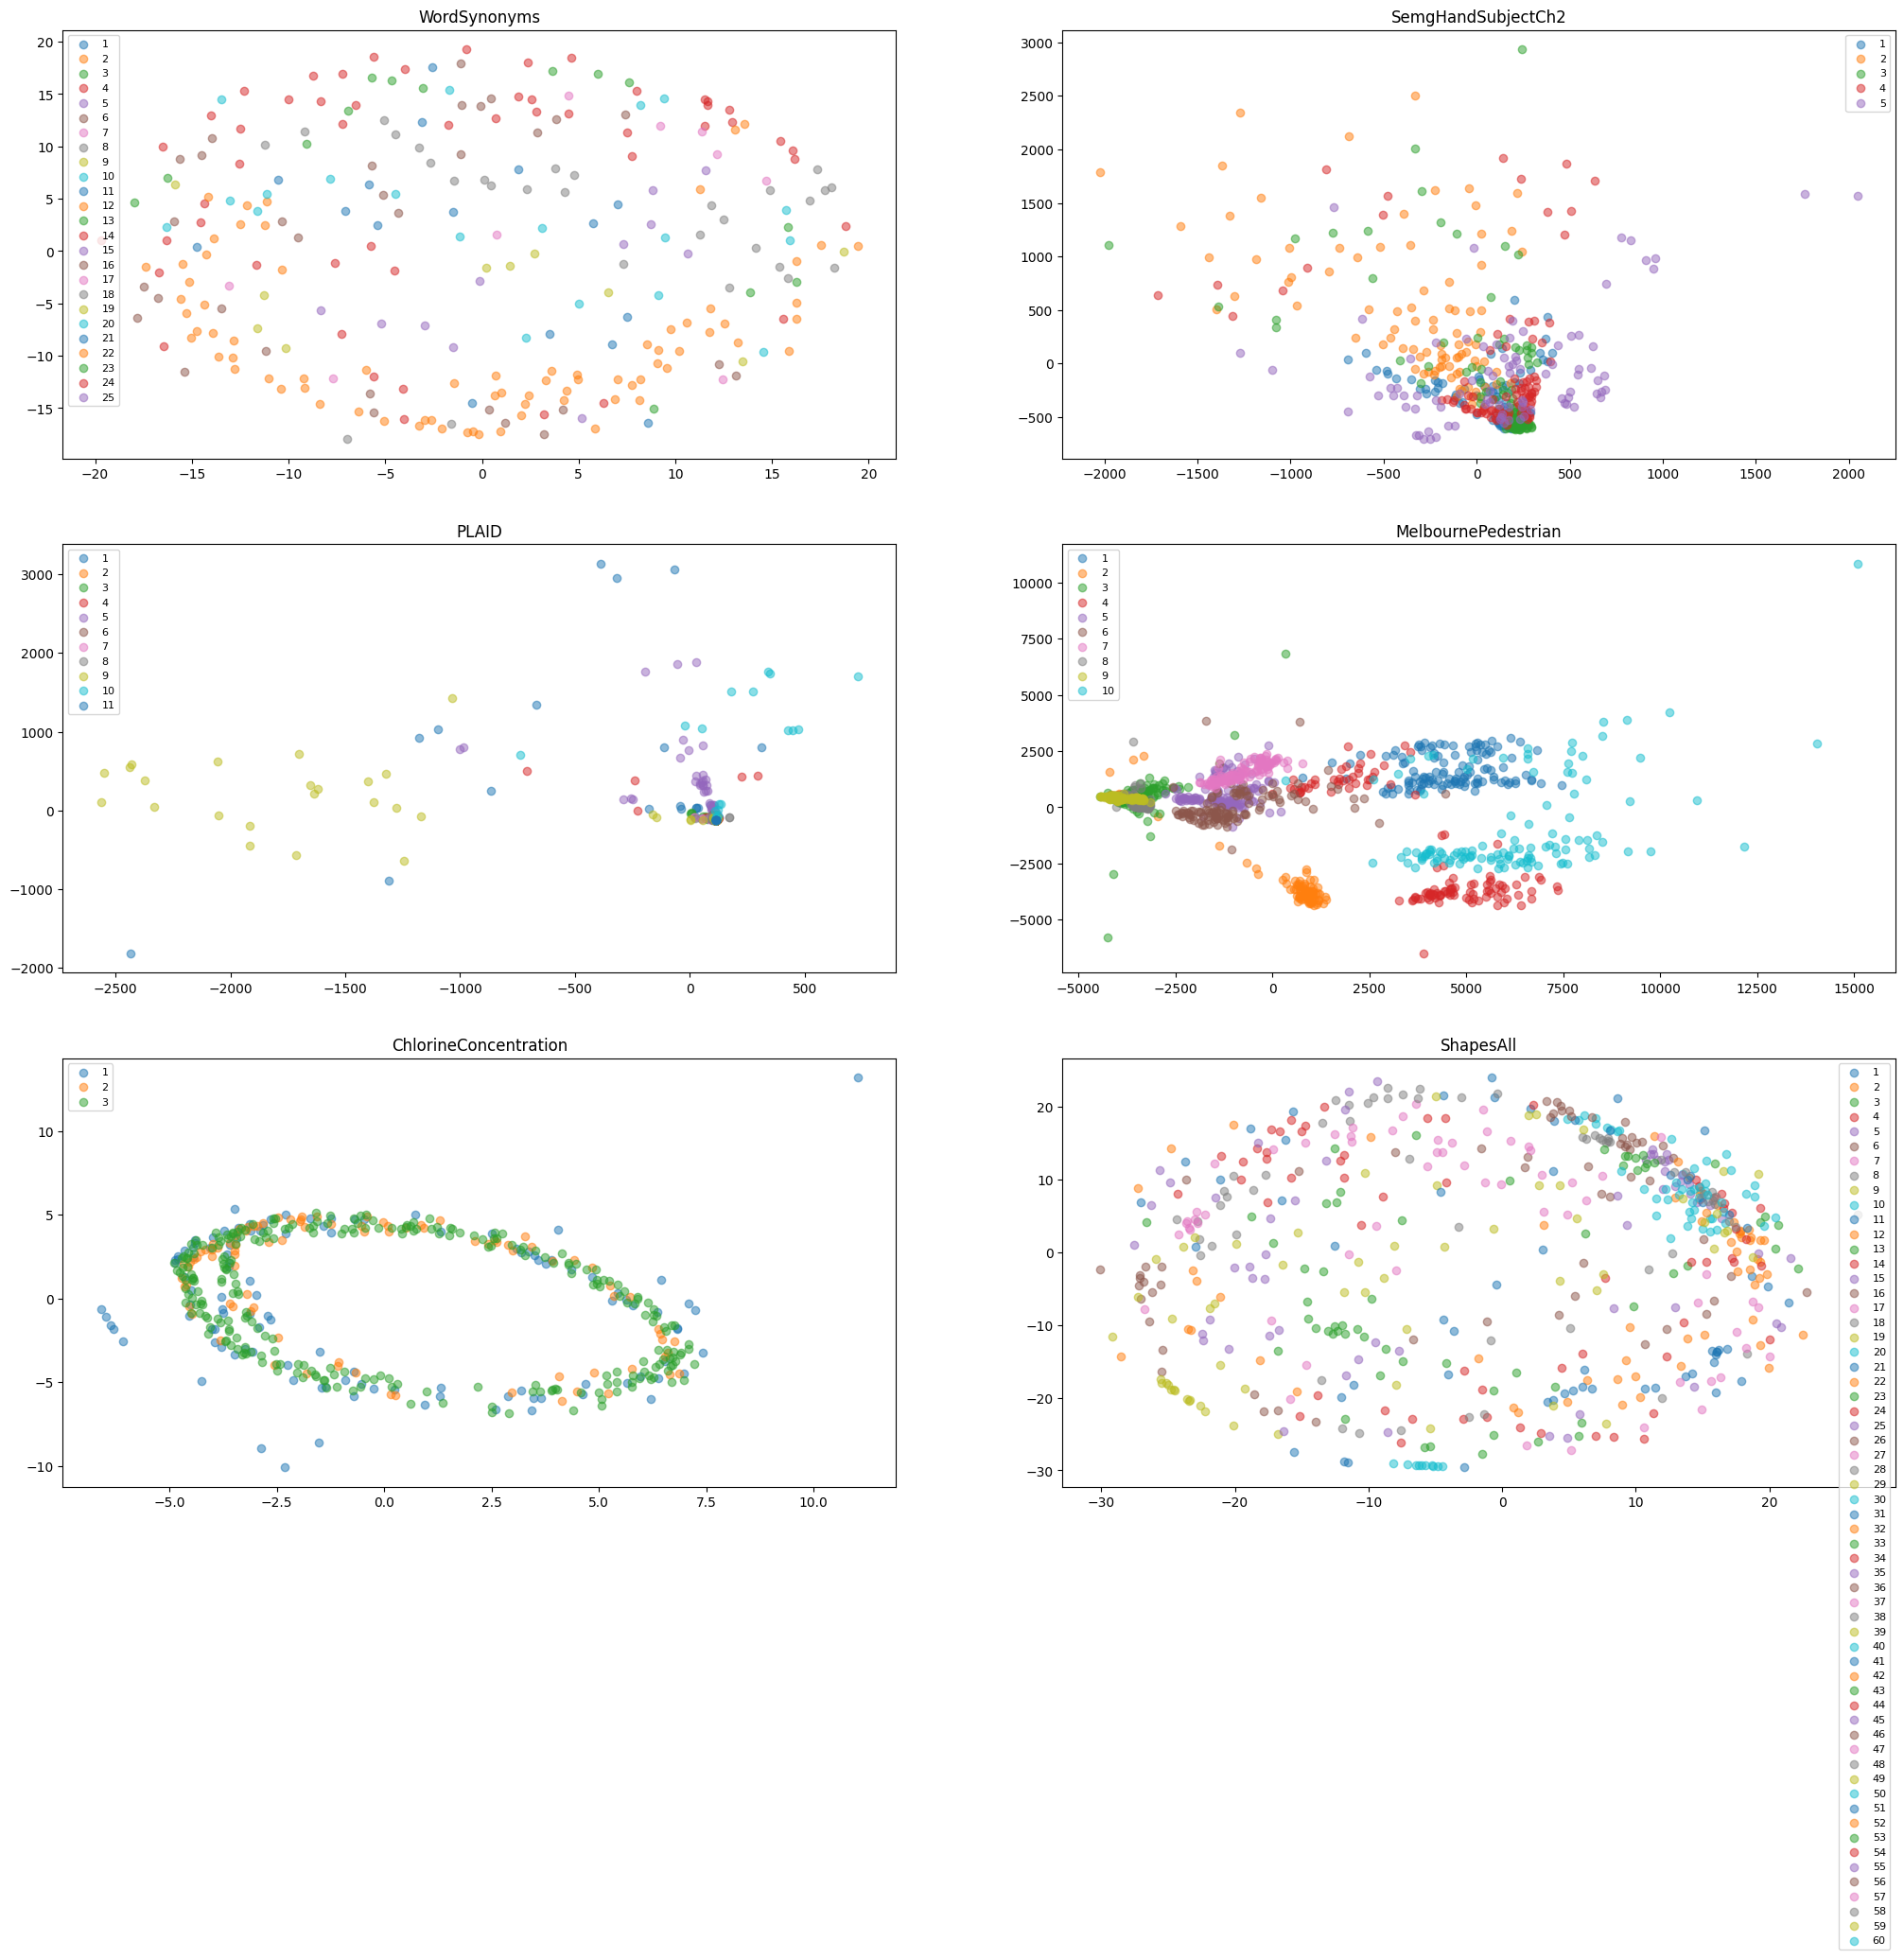

In [82]:
fig, axes = plt.subplots(3, 2, figsize=(25, 20))

def scatter_points(df_name, ax):
    X, y, X_test, y_test, df_errors = read_df(df_name)
    embedding = MDS(n_components=2)
    X_t = embedding.fit_transform(X)

    for cur_y in np.unique(y):
        ax.scatter(X_t[y==cur_y,0], X_t[y==cur_y,1], alpha=0.5)
    ax.legend(np.unique(y), fontsize=8, title_fontsize=8)
    ax.title.set_text(df_name)
    
for idx, df_name in enumerate(df_names):
    scatter_points(df_name, axes.flatten()[idx])

plt.savefig('scatter1.pdf')
plt.show()

### Teste de Hipotese (Nemenyi)

/tmp/ipykernel_264/3054699042.py:7: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = Orange.evaluation.compute_CD(avranks, df.shape[0],
/tmp/ipykernel_264/3054699042.py:9: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  Orange.evaluation.graph_ranks(avranks, df.keys(),


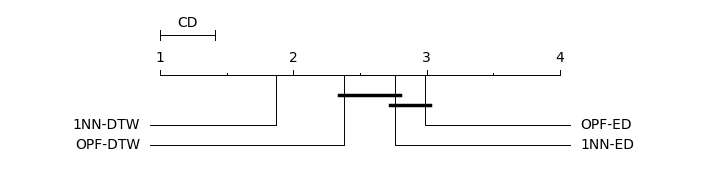

In [45]:
import Orange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

avranks = df.rank(axis=1,ascending=True).mean().values
cd = Orange.evaluation.compute_CD(avranks, df.shape[0], 
                                  alpha="0.05", test="nemenyi")
Orange.evaluation.graph_ranks(avranks, df.keys(), 
                              cd=cd, width=7, textspace=1.5)
plt.savefig('nemenyi.pdf', bbox_inches='tight')
plt.show();

# Boxplot

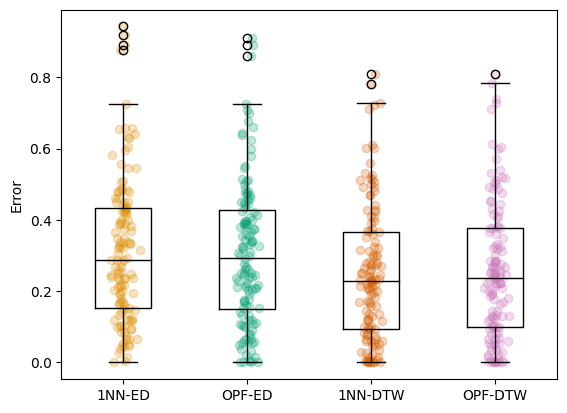

In [6]:
vals, names, xs = [],[],[]
for i, col in enumerate(df.columns):
    vals.append(df[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.04, df[col].values.shape[0]))  # adds jitter to the data points - can be adjusted

boxplot = plt.boxplot(vals, labels=names)
for median in boxplot['medians']:
    median.set_color('black')
palette = sns.color_palette("colorblind")[1:5]
for x, val, c in zip(xs, vals, palette):
    plt.scatter(x, val, alpha=0.25, color=c)
plt.ylabel('Error')
plt.savefig('boxplot.pdf', bbox_inches='tight')
plt.show()

In [23]:
df = df.round(4)

win = np.sum(df['OPF-ED'] < df['1NN-ED'])
draw = np.sum(df['OPF-ED'] == df['1NN-ED'])
loss = np.sum(df['OPF-ED'] > df['1NN-ED'])
assert(win+draw+loss == 128)

print(f"ED against ED: {win}/{draw}/{loss}")

win = np.sum(df['OPF-ED'] < df['1NN-DTW'])
draw = np.sum(df['OPF-ED'] == df['1NN-DTW'])
loss = np.sum(df['OPF-ED'] > df['1NN-DTW'])
assert(win+draw+loss == 128)

print(f"ED against DTW: {win}/{draw}/{loss}")

win = np.sum(df['OPF-DTW'] < df['1NN-ED'])
draw = np.sum(df['OPF-DTW'] == df['1NN-ED'])
loss = np.sum(df['OPF-DTW'] > df['1NN-ED'])
assert(win+draw+loss == 128)

print(f"DTW against ED: {win}/{draw}/{loss}")

win = np.sum(df['OPF-DTW'] < df['1NN-DTW'])
draw = np.sum(df['OPF-DTW'] == df['1NN-DTW'])
loss = np.sum(df['OPF-DTW'] > df['1NN-DTW'])
assert(win+draw+loss == 128)

print(f"DTW against DTW: {win}/{draw}/{loss}")

df.describe()

ED against ED: 37/25/66
ED against DTW: 35/7/86
DTW against ED: 85/7/36
DTW against DTW: 14/36/78


,1NN-ED,OPF-ED,1NN-DTW,OPF-DTW
count,128.000000,128.000000,128.000000,128.000000
mean,0.313754,0.304500,0.250844,0.254512
std,0.203079,0.202302,0.190430,0.190778
min,0.000000,0.000000,0.000000,0.000000
25%,0.152175,0.149300,0.094200,0.099800
50%,0.288050,0.293750,0.229150,0.236300
75%,0.434575,0.426525,0.367300,0.377125
max,0.942300,0.908700,0.807700,0.807700


In [65]:
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]